## Avi Chanales Hinge Data Challenge

### June 2021

## Table of contents
1. [Initial Data Exploration](#de)
2. [Question 1](#q1)
3. [Question 2](#q2)
3. [Question 3](#q3)

In [1]:
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
import datetime
from datetime import  timedelta
import matplotlib.style as style
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
import numpy as np
import math

In [2]:
#formatting
style.use('seaborn-poster')
sns.set_style('ticks')
style.use('ggplot')
sns.set_style({'font.sans-serif': 'DejaVu Sans'})
sns.set_style("whitegrid")
sns.set_palette(["#0274b6ff"])

## Initial Data Exploration <a name="de"></a>

In [4]:
## Load Data
users_raw = pd.read_csv('data/users.csv')
ratings_raw = pd.read_csv('data/ratings.csv')

I use the [pandas profiling pacakge](https://github.com/pandas-profiling/pandas-profiling) to perform a quick analysis of the raw data. It allows me to easily see descriptive statistics for each field, number of missing values, and distribution over values.

In [5]:
## Create profile report for each table
users_profile = ProfileReport(users_raw, title="Users DF Report")
ratings_profile = ProfileReport(ratings_raw, title="Ratings DF Report")

### View users.csv report

Some quick takeaways from the report
- there are the same number of distinct user_ids as there are rows so there are no duplicates in this dataset 
- there 448 rows with ios as the plastform instead of the more common spelling of iOS
- there are no missing values for profile_completion_ts suggesting that all users in this dataset completed thier profiles after registering

In [6]:
print('User profile completions range from {} to {}'.format(users_raw['profile_completion_ts'].min(),users_raw['profile_completion_ts'].max()))

User profile completions range from 2018-10-15 00:10:06 to 2018-11-14 23:59:47


#### Clean data

In [7]:
# standardize spelling of iOS
users_raw['platform'] = users_raw['platform'].replace({'ios':'iOS'})

In [8]:
## convert profile completion time to datetime object
users_raw['profile_completion_ts'] = pd.to_datetime(users_raw['profile_completion_ts'])
users_raw['registration_ts'] = pd.to_datetime(users_raw['registration_ts'])

### View ratings.csv report

There are no missing values in ratings.csv dataset. All data is as expected. The one interseting thing I noticed is the the minimum value for ct (number of ratings of a given type sent by user in a given minute) is 1 which means if a user opened the app and did no action (no skip or like) they would not be found in this table.

In [9]:
print('User ratings range from {} to {}'.format(ratings_raw['ts_minute'].min(),ratings_raw['ts_minute'].max()))

User ratings range from 2018-10-15 00:10:00 to 2018-11-17 00:00:00


#### Clean data

In [110]:
## convert ts_minute to datetime object
ratings_raw['ts_minute'] = pd.to_datetime(ratings_raw['ts_minute'])

## Question 1 <a name="q1"></a>

Q: Using only information in the datasets provided, how would you define next-day retention
rate of new users? (We will henceforth call this “retention rate”.) State your definition in
a way that someone else can compute the metric unambiguously.

##### Retention Rate Definition
I chose to define next-day retention as the proportion of new users who are perform at least 1 rating on the  the app the following calendar day after completing their profile. 

##### Rationale
An alternative approach would be to define "next day" as 24h period after the user completes their profile. I chose to use the calendar day for 2 reasons, one theoretical and on practical:

1. THEORETICAL: The psychological unit of days for users is in increments of calendar days not 24 hour periods since signing up for an app. For example a user that completes their profile at 7 PM on 11/22 and returns the next day 11/23 at 8PM would consider themselves as having returned to the app the next day.  Therefore, defining next-day retention as a user who returns the following calendar days betters alligns the metric with the behavioral patterns of the users that we want to ulimately measure and track. 
2. PRACTICAL: It is easier to have a metric defined at the calendar day to allow for easy interpertabiity and joining with other date-defined tables since there will be a retention rate value for each calendar date. 

##### Caveat
That said, there will be known edge cases for users who complete their profile late in the evening and dont stop using the app into the following day: For example a user who completed their profile at 11:59 PM and continued to use the app past 12:00 AM (i.e. the next calendar day) would get counted as being retained. 

##### Methodology 
To calculate next-day retention rate using the data provided I took the following steps:
1. Extracted the calendar date that each new user completed their profile from the timeseries provided
2. Added a field in users table for the next calendar day after profile completion
3. Calculated a user activity table that counted the number of minutes each user was active for each calendar day using the ratings table
4. Left joined the the user activity table to the users table on the user_id and day after profile completion to get the number of minutes each user was active the calendar day following completion
5. For users who were not active on the app the following day (i.e. their user_id was not found in ratings table) I filled their nan active minutes to 0.
6. Any user with active minutes > 0 on the following day was counted as active the following day (1) and those with 0 active minutes the following day were counted as inactive (0).
7. Next-day retention rate was then calculated as the number of users who were active the following day after profile completion / total number of new users

In [58]:
# exctract profile completion date from timestamp (2018-11-01 21:00:12 to 2018-11-01)
users_raw['profile_completion_date'] = users_raw['profile_completion_ts'].dt.date

## store day after completion date
users_raw['profile_completion_date_next_day'] = users_raw['profile_completion_date'] + timedelta(days=1)

## extract date from activity timeseries
ratings_raw['activity_date'] = ratings_raw['ts_minute'].dt.date

## create user-level table of number of minutes active per day. 
# Since a given user can have multiple entries per minutes depending on their activity 
# (1 for number of likes in minute, 1 for number of skips) I cacluted number of active minutes using nuniques(ts_minute)
user_active_days = (ratings_raw.groupby(['user_id','activity_date'])['ts_minute']
                    .nunique()
                    .reset_index()
                    .rename(columns={'ts_minute':'active_minutes'}))

## left join # of active minutes per day to users table on user_id and activity date = day after profile completion
users_activity_merged = pd.merge(users_raw, 
         user_active_days, 
         how = 'left', 
         left_on = ['user_id','profile_completion_date_next_day'], 
         right_on = ['user_id','activity_date'])

## convert NaN active minutes to 0 (i.e users that were not active the following day)
users_activity_merged['active_minutes'] = users_activity_merged['active_minutes'].fillna(0)

# if active minutes > 0 then 1 else 0
users_activity_merged['active_next_day'] = users_activity_merged['active_minutes'].apply(lambda x: 1 if x > 0 else 0)

In [59]:
print('The next day retention rate for the dataset provided is {}'.format(users_activity_merged['active_next_day'].mean()))

The next day retention rate for the dataset provided is 0.7647058823529411


This means roughly 76% of new users were active on the app the following day after completing their profile.

## Question 2 <a name="q2"></a>

Q: Hinge’s COO, Sam, claims that retention rates of Android and iOS users are different.
Does the data support Sam’s claim? Is the retention rate of users on one platform
consistently lower than that of the other?

First lets unpack Sam's claim and turn into a testable hyothesis. In a hypothesis testing framework Sam's hypothesis is that the retention rate for Android and iOS are different. Notably he does not claim which platform has the higher retention rate, only that the two rates are different from each other. In hypothesis testing this would be considered a two sided hypthoses (i.e. the hypthesis would be true if EITHER Android OR iOS had a higher retention rate). In this framework the null hypothesis would be that the rates across platforms are equal. 

Before getting into any statistcal analysis to test Sam's claim lets look at the data

In [60]:
users_activity_merged.groupby('platform')['active_next_day'].mean()

platform
Android    0.770056
iOS        0.756620
Name: active_next_day, dtype: float64

Across the entire dataset Android users have a slight retention advantage over iOS users with a 77% next-day retention rate compared to iOS users' 75.6%. However, lets see if this trend has been consistent over time. Below I plot the next day retention rate by day for each platform.

Text(0, 0.5, 'Retention Rate')

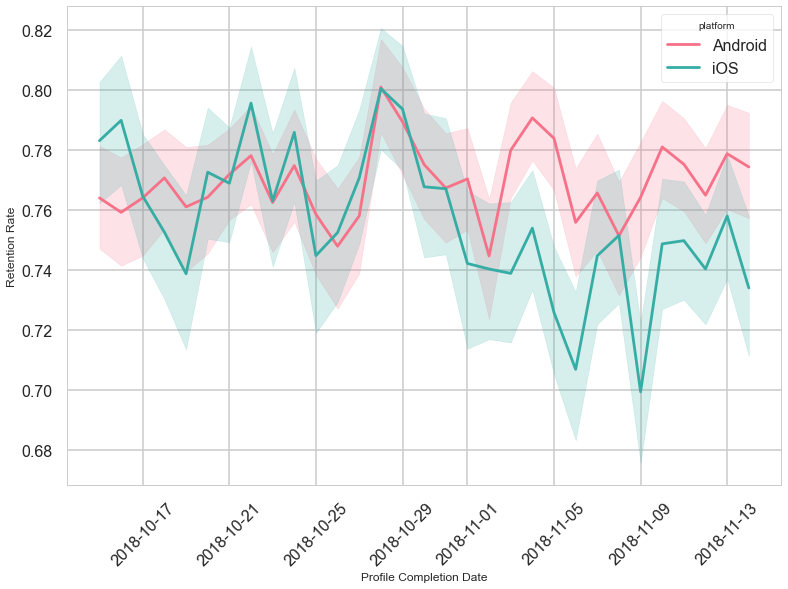

In [61]:
sns.lineplot(data = users_activity_merged, 
             x ='profile_completion_date',  
             y = 'active_next_day', 
             hue = 'platform')
          
plt.xticks(rotation = 45)
plt.xlabel('Profile Completion Date')
plt.ylabel('Retention Rate')

Intriguingly, it looks like Android and iOS retention rates were comparable until the beginning of November 2018 when iOS retention rates decreased while Android retention rates remained stable. For statistical analyses it is easier to summarize the data into 2 time bins: (1) prior to November 1, 2018 and (2) on or after November 1, 2018 to test for any changes in retention rate over time. Below I divided the data into the 2 time bins and plotted the retention rate for each platform as a function of time bin. In this visualization you can clearly see the trend found above. 

In [62]:
## divide data into new users prior to and on or after November 2018
users_activity_merged['after_2018_11_01'] = (users_activity_merged['profile_completion_date']
                                             .apply(lambda x: 1 if x >= datetime.date(2018, 11, 1) else 0))

Text(24.51104166666667, 0.5, 'Retention Rate')

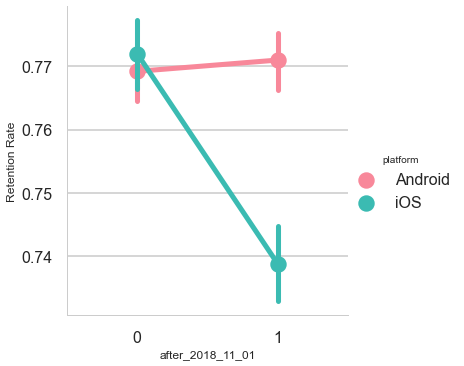

In [63]:
## plot
sns.catplot(data=users_activity_merged, 
            x = 'after_2018_11_01', 
            y = 'active_next_day', 
            hue = 'platform', 
            kind = 'point')

plt.ylabel('Retention Rate')

### Statistical Tests

Upon viewing the data I have three hypotheses to test:
  1. Prior to November 1, 2018 there was no difference in retention rate across Android and iOS
  2. After November 1, 2018 there was a difference in retention rate across Android and iOS
  3. There was a drop in retention rates on iOS devices after November 1, 2018
  
To test these hypothesis I will run a proportion z test to test if the proportions across the two samples I am comparing are the same. I will set an alpha level 0.05 for significance. If the p-value from the test is lower than the alpha level I will reject the null hypothesis that there is no difference between the two proportions because that would indicate that the difference in proportions between the two samples is unlikely to have arisen by chance. 

#### Function for running proportion z-test

In [64]:
def run_proportion_ztest(successes_a, successes_b, samples_a, samples_b):
    
    # create arrays of successes and samples
    successes = np.array([successes_a, successes_b])
    samples = np.array([samples_a, samples_b])
    
    # run proportion ztest
    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    
    return stat, p_value

#### Hypothesis 1

In [65]:
## ios vs android retention rate pre November 2018 

ios_retained = users_activity_merged.loc[(users_activity_merged['platform'] == 'iOS') 
                          & (users_activity_merged['after_2018_11_01'] == 0)]['active_next_day'].sum()
ios_sample_size = users_activity_merged.loc[(users_activity_merged['platform'] == 'iOS') 
                          & (users_activity_merged['after_2018_11_01'] == 0)]['user_id'].count()

android_retained = users_activity_merged.loc[(users_activity_merged['platform'] == 'Android') 
                          & (users_activity_merged['after_2018_11_01'] == 0)]['active_next_day'].sum()

android_sample_size = users_activity_merged.loc[(users_activity_merged['platform'] == 'Android') 
                          & (users_activity_merged['after_2018_11_01'] == 0)]['user_id'].count()


stat, p_value = run_proportion_ztest(ios_retained, android_retained, ios_sample_size, android_sample_size)
print('PRIOR TO NOVEMBER 2018 \niOS retention rate was {} \nAndroid retention rate was {} \nP value: {}'.format((ios_retained/ios_sample_size), (android_retained/android_sample_size),p_value))

PRIOR TO NOVEMBER 2018 
iOS retention rate was 0.771992968946179 
Android retention rate was 0.7692200050376424 
P value: 0.43018600007691243


Since the p-value is lower thatn the set alpha of 0.05 we cannot reject the null hyopthesis and thefore there is no statistically significant difference in the retention rates across platform prior to November 1 2018

#### Hypothesis 2

In [66]:
## ios vs android retention rate after November 2018 
ios_retained = users_activity_merged.loc[(users_activity_merged['platform'] == 'iOS') 
                          & (users_activity_merged['after_2018_11_01'] == 1)]['active_next_day'].sum()
ios_sample_size = users_activity_merged.loc[(users_activity_merged['platform'] == 'iOS') 
                          & (users_activity_merged['after_2018_11_01'] == 1)]['user_id'].count()

android_retained = users_activity_merged.loc[(users_activity_merged['platform'] == 'Android') 
                          & (users_activity_merged['after_2018_11_01'] == 1)]['active_next_day'].sum()

android_sample_size = users_activity_merged.loc[(users_activity_merged['platform'] == 'Android') 
                          & (users_activity_merged['after_2018_11_01'] == 1)]['user_id'].count()


stat, p_value = run_proportion_ztest(ios_retained, android_retained, ios_sample_size, android_sample_size)

print('AFTER NOVEMBER 2018 \niOS retention rate was {} \nAndroid retention rate was {} \nP value: {}'.format((ios_retained/ios_sample_size), (android_retained/android_sample_size),p_value))

AFTER NOVEMBER 2018 
iOS retention rate was 0.7387820512820513 
Android retention rate was 0.7710032691147999 
P value: 4.5223048386481356e-17


The p-value is lower than the set alpha of 0.05 so we can reject the null hyopthesis and state that there is iOS retention rates were significantly lower than Android retention rates after November 1, 2018

#### Hypothesis 3

In [67]:
## ios retention rate pre November 2018 vs post November 2018

ios_retained_pre = users_activity_merged.loc[(users_activity_merged['platform'] == 'iOS') 
                          & (users_activity_merged['after_2018_11_01'] == 0)]['active_next_day'].sum()
ios_sample_size_pre = users_activity_merged.loc[(users_activity_merged['platform'] == 'iOS') 
                          & (users_activity_merged['after_2018_11_01'] == 0)]['user_id'].count()

ios_retained_post = users_activity_merged.loc[(users_activity_merged['platform'] == 'iOS') 
                          & (users_activity_merged['after_2018_11_01'] == 1)]['active_next_day'].sum()
ios_sample_size_post = users_activity_merged.loc[(users_activity_merged['platform'] == 'iOS') 
                          & (users_activity_merged['after_2018_11_01'] == 1)]['user_id'].count()


stat, p_value = run_proportion_ztest(ios_retained_pre, ios_retained_post, ios_sample_size_pre, ios_sample_size_post)
print('IOS COMPARISON \niOS retention rate pre November 2018 was {} \niOS retention rate post November 2018 was {} \nP value: {}'.format((ios_retained_pre/ios_sample_size_pre), (ios_retained_post/ios_sample_size_post),p_value))

IOS COMPARISON 
iOS retention rate pre November 2018 was 0.771992968946179 
iOS retention rate post November 2018 was 0.7387820512820513 
P value: 3.9790709645858037e-16


The p-value is lower than the set alpha of 0.05 so we can reject the null hyopthesis and state that there was a significant drop in iOS retention rates after November 1, 2018

### Summary


In sum, Sam is partially correct. Retention rates across iOS and Android have NOT been consistenly different. It appears that starting around November 1, 2018 there was a significant drop (~4%) in iOS retention rates for iOS devices causing iOS retention rates to significantly differ from Android rates. 

## Question 3 <a name="q3"></a>

### a. What insights can you mine from the data that may be relevant to explaining the difference?

Before doing an extensive deep dive lets first check to see that there was not any anamolous drop in new users for ios after November 2018. Below is a plot of new users on ios and Android pre/post November 2018. You can see there was a drop in new users across Android and ios devices but the drop is proportional across platforms and therefore is unlikely to explain the difference in retention rate. 

Text(0, 0.5, 'New Users')

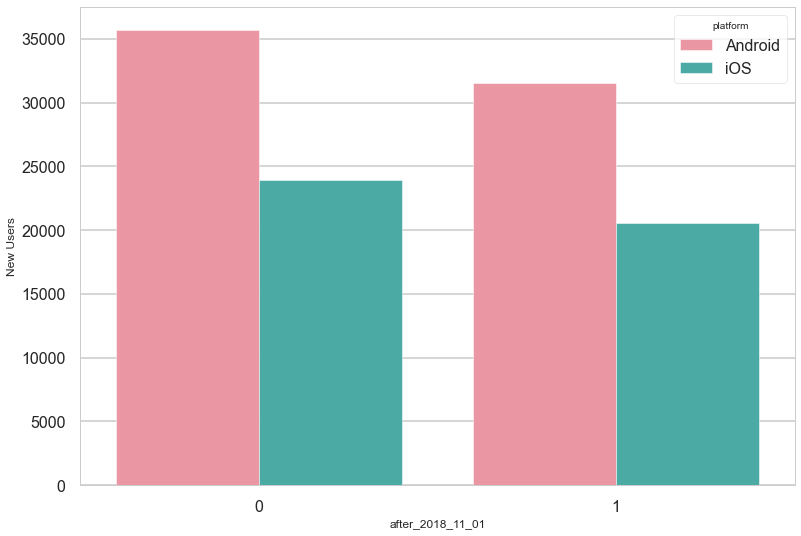

In [68]:
sns.countplot(data=users_activity_merged, 
            x = 'after_2018_11_01',  
            hue = 'platform')

plt.ylabel('New Users')

Before diving into more data mining I think it would be helpful to build an explanatory model that explains which factors contribute most (and how) to retention generally to limit the data mining expedition to factors that could have the most explanatory power in understanding the drop in iOS retention rate. 

### b. What are some factors that seem to contribute to retention in general?


### Model Overview

To get a quick and rough estimate of which features contribute  to retention generally I ran a logistic regression model using a subset of the dataset provided. The dependent variable for the model was a user's retention satus (1 they were retained; 0 they were not retained) and the independet variables were features engineered from the dataset provided (see below for list of features used). I chose to keep the model simple by only selecting features that (1) I believed could reasonably effect retention rate (2) could inform product decisions and (3) were not highly correlated with another feature. The magnitude of the model's weights for each feature will inform which features are important predictors of retention and the direction (positive/negative) will inform in what what they are related to retention.

### List of Features

Not Engineered
- **age**: user's age
- **gender**: user's gender
- **max_distance**: maximum distance (in miles) that user is willing to consider
- **photo_count**: number of photos user has uploaded to profile

Engineered
- **age_pref_range**: range of user's age range preferences (age_range_max - age_range_min)
- **height_pref_range**: range of user's height range preferences (height_range_max - height: _range_min)
- **minutes_active_first_day**: # of minutes a user was active on the day of profile completion
- **prop_likes_first_day**: % of likes given out of total ratings given (likes + skips) on the day of profile completion
- **registration_completion_time_min**: time in minutes from registration to profile completion
- **day of week**: day of week the user completed their profile (one-hot encoded)
- **time of day**: time of day. Values include "morning" 6 AM - 12PM; "afternoon" 12 PM - 6 PM; "evening": 6-12 AM; "night" 12 AM - 6 AM (one-hot encodded)


### Feature Engineering

###### 1. registration_completion_time_min

In [69]:
users_activity_merged['registration_completion_time_min'] = (users_activity_merged['profile_completion_ts'] 
                                                             - users_activity_merged['registration_ts']).astype('timedelta64[m]')

###### 2. age_pref_range

In [70]:
users_activity_merged['age_pref_range'] = (users_activity_merged['age_pref_max'] 
                                           - users_activity_merged['age_pref_min'])

##### 3. height_pref_range

In [71]:
users_activity_merged['height_pref_range'] = users_activity_merged['height_pref_max'] - users_activity_merged['height_pref_min']

##### 4. prop_likes_first_day


In [72]:
## count user ratings per rating type per day
user_ratings_per_day = (ratings_raw.groupby(['user_id','activity_date','rating_type'])['ct']
                    .sum()
                    .reset_index()
                    )

## pivot 
user_activity_day_pivoted = pd.pivot_table(user_ratings_per_day, 
                                           index = ['user_id','activity_date'], 
                                           columns='rating_type', 
                                           values = 'ct').rename(columns={1:'likes', 0:'skips'})

## compute proption likes for each day
user_activity_day_pivoted['prop_likes_first_day']  = (user_activity_day_pivoted['likes']/ 
                                            (user_activity_day_pivoted['likes'] + user_activity_day_pivoted['skips']))


## left join with df on profile completion date
users_activity_merged = pd.merge(users_activity_merged, 
                                 user_activity_day_pivoted, 
                                 how = 'left', 
                                 left_on =['user_id', 'profile_completion_date'],
                                 right_on = ['user_id', 'activity_date'])

## fill 0 for users with no activity on first day
users_activity_merged['prop_likes_first_day'] = users_activity_merged['prop_likes_first_day'].fillna(0)

##### 5. active_minutes_first_day

In [73]:
## left join # of active minutes per day on profile completion date
users_activity_merged = pd.merge(users_activity_merged, 
         user_active_days.rename(columns = {'active_minutes':'active_minutes_first_day'}), 
         how = 'left', 
         left_on = ['user_id','profile_completion_date'], 
         right_on = ['user_id','activity_date'])

## fill 0 for users with no activity on first day
users_activity_merged['active_minutes_first_day'] = users_activity_merged['active_minutes_first_day'].fillna(0)

##### 6. time_of_day

In [74]:
## extract hour from profile completion time
users_activity_merged['profile_completion_hour'] = users_activity_merged['profile_completion_ts'].dt.hour

# create dictionary mapping tod to hours
tod_dict = {
    "morning" : list(range(6,12)),
    "afternoon": list(range(12,18)),
    "evening": list(range(18,24)),
    "night": list(range(0,6)),
     }

## invert dictionary
def invert(d):
    return dict( (v,k) for k in d for v in d[k] )

inv_tod_dict = invert(tod_dict)

## map hour of completion to tod
users_activity_merged['tod'] = users_activity_merged['profile_completion_hour'].map(inv_tod_dict)

##### 7. day_of_week

In [75]:
## extract day of week from profile completion time
users_activity_merged['profile_completion_dow'] = users_activity_merged['profile_completion_ts'].dt.dayofweek

# create dictionary mapping day of week number to string
dow_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri',5: 'Sat',6: 'Sun'}

## map day of week number to profile completion dow
users_activity_merged['dow'] = users_activity_merged['profile_completion_dow'].map(dow_dict)

### Model Setup

In [76]:
## assign dependent variable name and features we want to include in model
cols_to_use = ['active_next_day', 'gender', 'age', 'age_pref_range', 'height_pref_range', 'photos_count', 
               'registration_completion_time_min',  'max_distance',
               'dow', 'tod','prop_likes_first_day', 'active_minutes_first_day']

## select features from dataset
users_activity_merged_use = users_activity_merged[cols_to_use]


## one hot encode tod and dow
users_activity_merged_use= pd.concat([users_activity_merged_use, 
                                   pd.get_dummies(users_activity_merged_use.tod, prefix='tod')], 
                                  axis = 1)

users_activity_merged_use = pd.concat([users_activity_merged_use, 
                                   pd.get_dummies(users_activity_merged_use.dow, prefix='dow')], 
                                  axis = 1)

## Since there are not many nulls I will drop all rows with null values
users_activity_merged_use = users_activity_merged_use.dropna()


## create X and y tables for model fitting
X = users_activity_merged_use.drop(columns=['active_next_day','education_attained', 'tod', 'dow'])
y = users_activity_merged_use['active_next_day']

## standardize units by dividing by std
for feature in X.columns:
    X[feature] = X[feature]/ X[feature].std()

### Run Model and Plot Feature Weights

Optimization terminated successfully.
         Current function value: 0.454330
         Iterations 7


<AxesSubplot:ylabel='feature'>

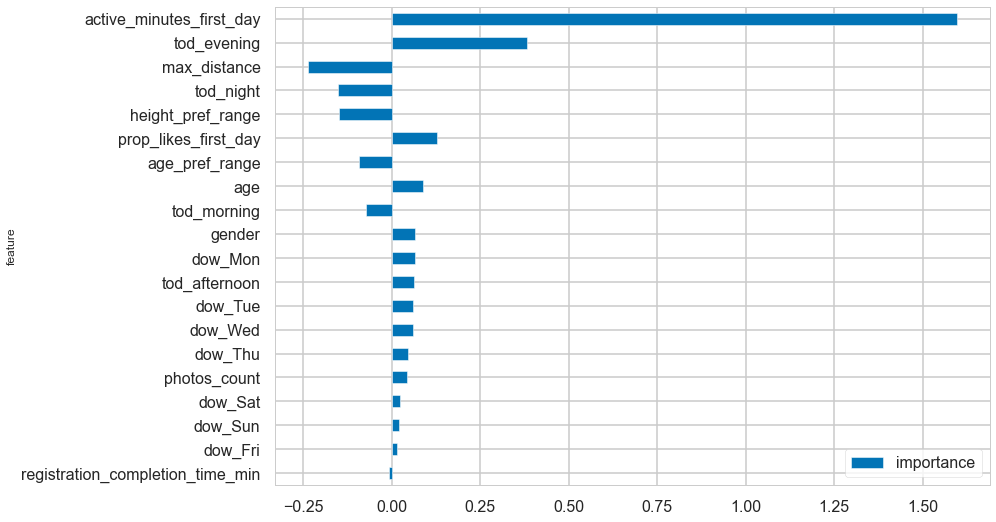

In [77]:
## run model 
log_reg = sm.Logit(y,X).fit()

## extract weights (coefs) from model and save in df
feature_importance = (pd.DataFrame(log_reg.params)
                      .reset_index()
                      .rename(columns={'index':'feature',0:'importance'}))

## take absolute value of weights and sort df 
feature_importance['abs_importance'] = abs(feature_importance['importance'])
feature_importance = feature_importance.sort_values(by =['abs_importance'], ascending = True)

## Plot
feature_importance.plot.barh(x='feature',y='importance')

The magnitude of the weights is directional with how important that feature is in predicting retention and the sign of the weights indicate whether higher (positive) or lower (negative) values of that feature relate to increased odds of retention. 

Looking at the feature weights we can infer some general rules about what contributes to retention.

**1. Greater active time on a users first day is related to higher likelihood of retention**
   - The most important feature in predicting retention is how many minutes a user was active on their first day on the app. This suggests that designing product features that get users swiping on day 1 could help increase retention.


**2. Narrower preference ranges increases likelihood of retention** 
   - Interestingly age, height, and distance ranges all have negative feature weights suggesting narrower preference ranges are related to higher likelihood of retention. Why? This data does not directly answer why but its possible that users are more likely to find matches they are interested in if they correctly allign their preference ranges with their actual preferences. 
    
    
**3. Finding potential matches leads to higher likelihood of retention**
   - Not only is active time on the first day important but the proption of likes a user gives during that active time also increases the likelihood of retention. This makes sense as if a user thinks there is potential to find a match they are more likely to return the next day. 

**4. Time a user spends creating a profile is not predictive of retention**
  - The two features that suggest investment in time creating profile, (1) time between registration and profile completion and (2) photos uploaded, both have low importance in predicting retention. Completing and investing time in a quality profile is obvioulsly important to improve the likelihood a user will have long term success on the app however it is not predictive of whether a new users will come back the following day after signing up. This insight could be important to keep in mind when deciding which product features to prioritize depending on broader company goals. 
      

Also of note higher age and being gender 1 (unkown which gender maps onto which number) increase likelihood of retention although this is less actionable for product decisions. 

### a (again). What insights can you mine from the data that may be relevant to explaining the difference?


Now that I have a rough understanding of how features relate to retention generally I can do some data mining on the data to see if I can find any clues as to what might be causing the drop in iOS retention rates. 

For a feature to be a good explanation for contributing to the drop in iOS retention data it should meet the following criterion:
 1. Show a selective change in its value on iOS devices from before November 1, 2018 to after. By selective I mean the change should happen for iOS users but there should be no or little change for Android users.
 
 
 2. The feature changing for iOS users should change in a direction that is consistent with an increased likelihood of retention from the model. If there was an increase in the average value of feature for iOS users but from the model we know that an increase in that feautre is related to an increase in likelihood than it follows that this would not a good explanation for contributing to a DESCREASE in retention rate for ios users.
 
For data mining I took the approach of visualizing the change in the average feature value (for features used in the model) from before November 1, 2018 to after for each platform. I sorted the visualizations by the difference in % change over time between ios and android users to focus attention to features that had a largest change across the two platforms. 

##### Calculate % change over time by platform

In [78]:
## function for computing % change 
def platform_percent_change(df, variable):
    
    g= df.groupby(['after_2018_11_01','platform'])[variable].mean().reset_index()

    android_pre = g.loc[(g['platform'] == 'Android')  & (g['after_2018_11_01'] == 0)][variable].values[0]
    android_post = g.loc[(g['platform'] == 'Android')  & (g['after_2018_11_01'] == 1)][variable].values[0]

    ios_pre = g.loc[(g['platform'] == 'iOS')  & (g['after_2018_11_01'] == 0)][variable].values[0]
    ios_post = g.loc[(g['platform'] == 'iOS')  & (g['after_2018_11_01'] == 1)][variable].values[0]

    ios_perc_change = (ios_post-ios_pre)/ios_pre*100
    android_perc_change = (android_post-ios_pre)/android_pre*100
    
    return ios_perc_change, android_perc_change

## select features to plot
features =  ['gender', 'age', 'age_pref_range', 'height_pref_range', 'photos_count', 
               'registration_completion_time_min',  'max_distance', 
               'prop_likes_first_day', 'active_minutes_first_day']

## create empty df
df = pd.DataFrame(index = features, columns = ['ios_perc_change', 'android_perc_change'])

## fill in % change data for each variable/platform
for feature in features:
    ios_perc_change, android_perc_change = platform_percent_change(users_activity_merged, feature)
    
    df.loc[feature,'ios_perc_change'] = ios_perc_change
    df.loc[feature,'android_perc_change'] = android_perc_change
 
# calculate difference in % change between ios and android
df['diff'] = df['ios_perc_change'] - df['android_perc_change']
df['abs_diff'] = abs(df['diff'])
df = df.reset_index().rename(columns = {'index':'variable'})

##### Melt users activity df to create long df for easy plotting in seaborn

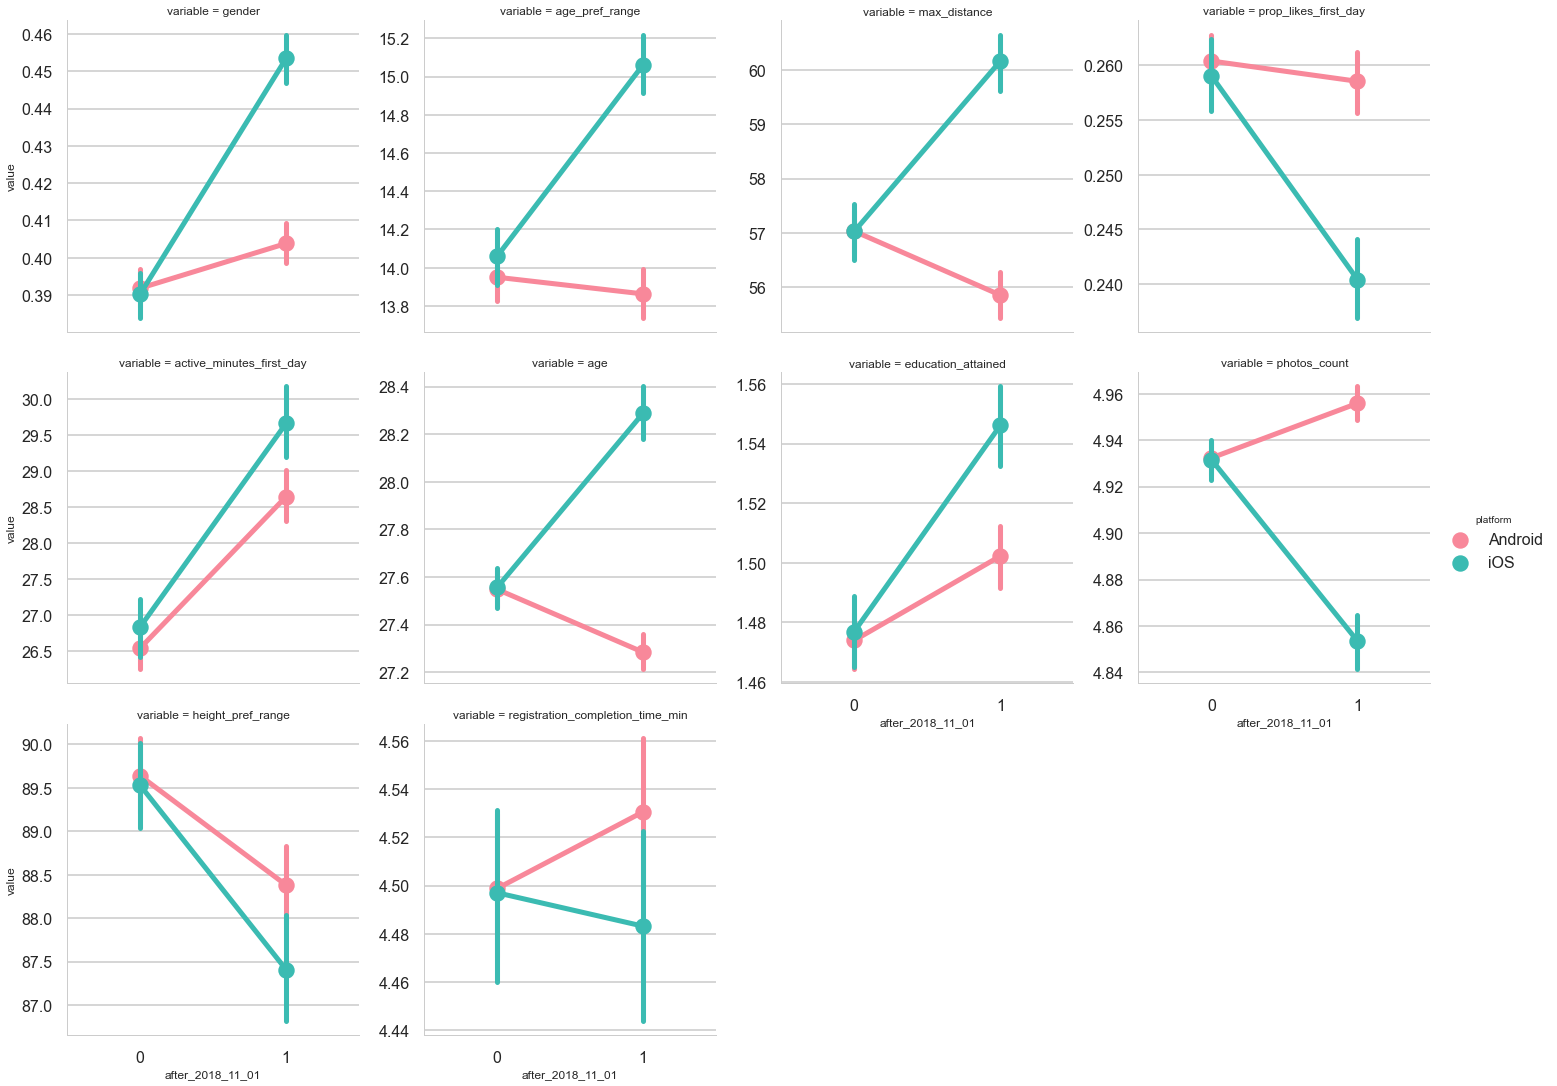

In [89]:
# melt df
melted = pd.melt(users_activity_merged, id_vars = ['platform', 'after_2018_11_01'], value_vars = features)

## merge with % change df
melted_merged = pd.merge(melted, df, how = 'left', on = 'variable')


# plot and order by abs(% change difference between android and ios)
sns.catplot(data=melted_merged.sort_values(by = ['abs_diff'], ascending = False), 
            x = 'after_2018_11_01', 
            y = 'value', 
            hue = 'platform', 
            col = 'variable', 
            hue_order = ['Android','iOS'],
            col_wrap = 4, 
            kind = 'point', 
            sharey = False)

When looking at the initial pattern of results it seems like there is no smoking gun feature contributing to the decrease in iOS retention rate. 

There are some features, such as gender, max distance, and age that show the selective pattern of an increase in their average values for ios users, however, these increases should contribute to an INCREASE in retention rate for ios users based on the model's weights. 

There are only 2 features that show a selective change for ios users in a direction compatibale with a decrease in retention rate: (1) age preference range and (2) proportion likes on the first day. New IOS users after Novermber 2018 showed a selective increase in their age preference range which the model found decreased likelihood of retention. Similarly new ios users after November 2018 showed a selective decrease in their proportion of likes given on the first day which again the model found decreased likelihood of retention. 

In fact, if you plot the daily timeseries of the average value for each of these features by platform you see a noticable divergence between ios and android at the same time I observed the change in retention rate. For both these featues the change for iOS users persists similar to the change in retention rate. Both of these changes would be good to investigate further, however, its hard to come up with an explanation for how these changes could have arisen only for iOS users. 

#### Age Preference Range

Text(0.5, 0, 'Age Preference Range')

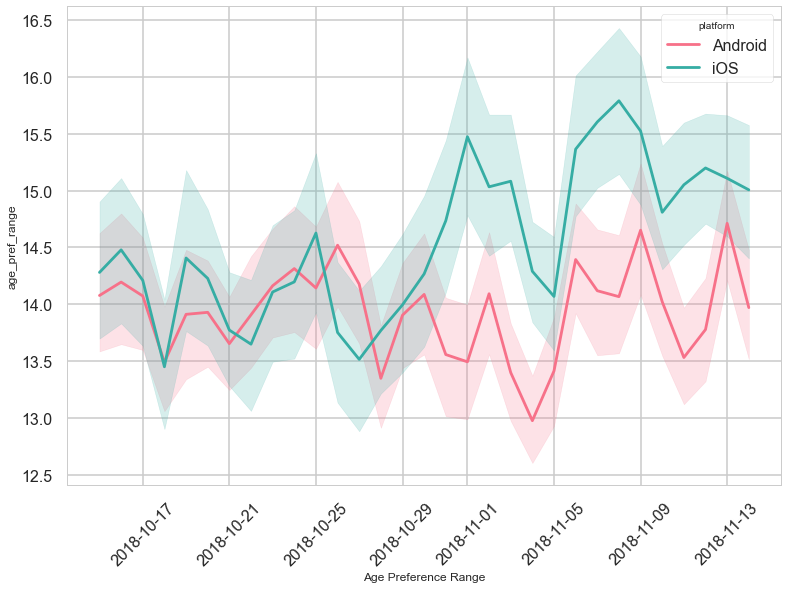

In [90]:
sns.lineplot(data = users_activity_merged, 
             x ='profile_completion_date',  
             y = 'age_pref_range', 
             hue = 'platform')

plt.xticks(rotation = 45)
plt.xlabel('Profile Completion Date')
plt.xlabel('Age Preference Range')

#### % Likes Given First Day

Text(0, 0.5, '% Likes Given First Day')

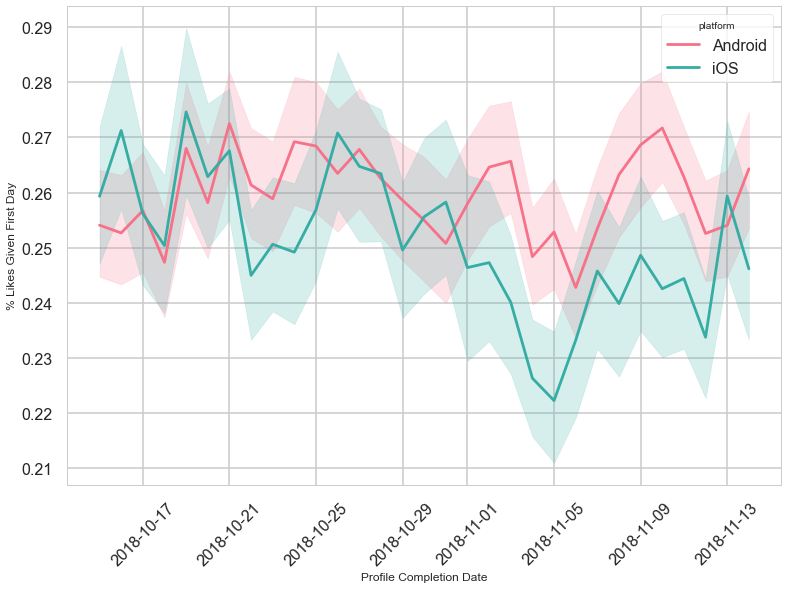

In [92]:
sns.lineplot(data = users_activity_merged, 
             x ='profile_completion_date',  
             y = 'prop_likes_first_day', 
             hue = 'platform')

plt.xticks(rotation = 45)
plt.xlabel('Profile Completion Date')
plt.ylabel('% Likes Given First Day')

When taking a step back and thinking more broadly about potential reasons for the drop in iOS retention rate a difference between platforms that comes to mind from experience is how iOS and Android handle push notifications. Indeed, there was a change to the ios system in 2018 that allowed users to opt in to quite push delivery which has had documented effects of a decrease in CTR from push notifications on ios compared to Android. If push notificatios are major source of app visits than this change in push notification efficacy on iOS could explain why fewer new users would return the next day. I wasn't provided data on how a user started a session but I thought one way to test for this effect would be to see if there was a difference in the average number of visits (sessions) for new users who did return the next day. The thought being that if there was a decrease in the efficacy of push notifications on ios devices then you would see a decrease in the # of app visits the following day even for users who returned since some proportion of push notifications alerting about a new like or match would no longer be as effective. 

#### Calculating return visits within a day

I defined a new visit as activity after at least 10 minutes of no activity

Text(0, 0.5, 'Number of App Visits Next Day')

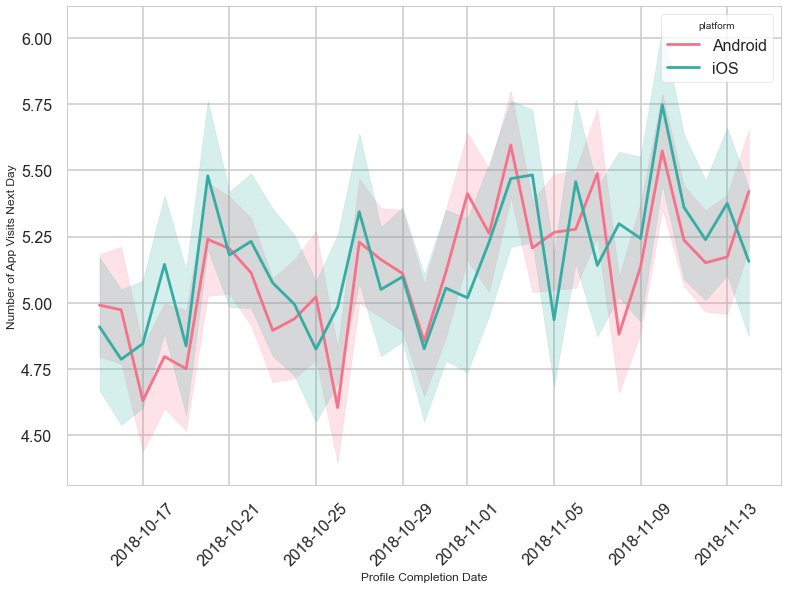

In [108]:
# get unique active minutes per user per day
ratings_raw_unique_minutes = (ratings_raw.groupby(['user_id', 'activity_date','ts_minute'])['rating_type']
                              .count()
                              .reset_index())

# for each minute get next minute of activity within a day
ratings_raw_unique_minutes['ts_minute_lagged'] = (ratings_raw_unique_minutes.groupby(['user_id', 'activity_date'])['ts_minute']
                                                  .shift(1))

# for active minute compute time since last activity 
ratings_raw_unique_minutes['time_since_last_activity'] = (ratings_raw_unique_minutes['ts_minute']
                                                          - ratings_raw_unique_minutes['ts_minute_lagged'] 
                                                          ).astype('timedelta64[m]')

# new visit is activity after at least 10 minutes of no activity
ratings_raw_unique_minutes['new_visit'] = (ratings_raw_unique_minutes['time_since_last_activity']
                                           .apply(lambda x: 1 if (x >= 10 or math.isnan(x)) else 0))

# for each user count # of new visits per day
users_sessions_per_day = (ratings_raw_unique_minutes.groupby(['user_id','activity_date'])['new_visit']
                          .sum()
                          .reset_index()
                          .rename(columns = {'new_visit':'number_of_visits'}))

# inner join to user activity table on day after completion to get df of only users who returend
next_day_num_visits = pd.merge(users_activity_merged,
                                users_sessions_per_day, 
                                how = 'inner', 
                                left_on = ['user_id', 'profile_completion_date_next_day'],
                                right_on = ['user_id','activity_date'])

# plot daily timeserirs of  average # of visits for new users next day by platform
sns.lineplot(data = next_day_num_visits[next_day_num_visits['active_next_day'] == 1], 
             x ='profile_completion_date',  
             y = 'number_of_visits', 
             hue = 'platform')

plt.xticks(rotation = 45)
plt.xlabel('Profile Completion Date')
plt.ylabel('Number of App Visits Next Day')

There is no noticable decrease in the number of visits on a new users' next day on ios suggesting my hypothesis about differences in push notification efficacy might be wrong. 

### C. State a hypothesis about how retention can be improved, and design an experiment to test your hypothesis.

Based on the findings from the model above that users who spend more time on the app the day they complete their profile have a higher likelihood of retention, I would suggest an experiment that aims to increase the time spent on app the first day a user completes their profile to increase retention. 

##### Hypothesis
My hypothesis is that users who spend more active time on the app on their first day have a higher retention rate than users who spend less active time on the app on their first day. 

##### Design
To test this hypothesis I would run an A/B experiment that tested an app design feature that was designed with the goal of increasing active time for new users who completed their profile but did not do any rating. I would suggest that this feature be a notification sent to users who signed up for the app but did not rate any users within 2 hours of completing their profile. The notification would be a gentle message prompting them that there are matches waiting for them. To run the experiment I would radnomly assign new users into the group that will recieve the notification (experimental group) and a group that would not recieve the notification (control group). I would conduct a power analysis to estimate how long to run the experiment in order to have enough statistical power to detect a significant difference in retention rates between the two groups.

##### Analysis
After running the experiment I would first test to see that the notification manipulation was effective at increasing active time on a new user's first day using a t-test to compare the mean active time between the two groups. If this manipulation was successfull at increasing active time on the app for the experimental group, I would then test to see whether the experimental group also showed higher retention rates compared to the control group using a proption z-test (as used above). 